Groundwater | Case Study
# Template Student Task: Groundwater Well Group Impact Assessment
Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

## 1 Overview and Learning Objectives

In this case study, you are tasked with **evaluating the impact of a well group on the regional groundwater flow field** through a comprehensive three-stage modeling approach:

1. **Base model (no wells)**: Regional groundwater conditions without your assigned well group operating
2. **Base model with wells**: Current groundwater extraction/injection rates at your assigned well group implemented in the telescope submodel
3. **Scenario conditions**: Modified forcing conditions (e.g., changed recharge, boundary conditions, or pumping rates) implemented in the regional model, with impacts assessed through the telescope submodel

This notebook demonstrates the complete **telescope modeling workflow** (also called sub-modeling or child modeling approach) that you will use to complete your assessment. The telescope approach involves:

- Creating a **high-resolution submodel** in the area of interest around your well group
- Extracting **boundary conditions** from the regional parent model to properly nest the submodel
- Running three sequential simulations to assess cumulative and scenario-specific impacts
- Comparing results to quantify changes in groundwater flow patterns, drawdowns, and capture zones


### 1.1 Why Use the Telescope Approach?

The telescope approach is essential because:
- **Computational efficiency**: We can achieve fine-scale resolution (5m cells) around wells without requiring the entire regional model to be refined
- **Proper boundary conditions**: The submodel receives realistic boundary conditions from the regional model simulation
- **Scale-appropriate analysis**: Local well impacts require high resolution that regional models cannot provide efficiently
- **Industry standard**: This nested modeling approach is widely used in professional groundwater consulting
- **Scenario flexibility**: Changes to regional forcings can be easily propagated to the local scale

### 1.2 Three-Stage Modeling Workflow

**Stage 1: Base Regional Model (No Wells)**
- Run regional model without well group to establish baseline conditions
- Extract boundary conditions for telescope submodel
- Document natural groundwater flow patterns in the submodel

**Stage 2: Base Model with Wells**  
- Implement well group in telescope submodel using Stage 1 boundary conditions
- Assess direct impact of well operations on local flow field
- Quantify drawdowns and capture zones under current conditions

**Stage 3: Scenario Assessment**
- Modify forcing conditions in regional model (e.g., changed recharge, boundary conditions)
- Re-extract boundary conditions from updated regional model
- Run telescope submodel with new boundary conditions to assess combined impacts
- Compare Stage 3 vs Stage 2 in the submodel to isolate scenario-specific effects

### 1.3 Your Task

1. **Copy and adapt this notebook** for your specific well group configuration
2. **Modify the parameters** in the case_config.yaml and in your copy of this notebook (group number, buffer distances, pumping rates) as needed for your assignment
3. **Execute the three-stage workflow** systematically
4. **Analyze and compare results** between all three stages to understand:
   - Direct well impacts (Stage 2 vs Stage 1)
   - Scenario impacts (Stage 3 vs Stage 2)  
   - Combined effects (Stage 3 vs Stage 1)
5. **Document your findings** for inclusion in your final report and presentation

The results from your three-stage submodel analysis will form a key component of your **final report and presentation**, demonstrating your understanding of groundwater flow processes, numerical modeling techniques, and scenario assessment at multiple scales.

3. **Execute the three-stage workflow** systematically
4. **Analyze and compare results** between all three stages to understand:
   - Direct well impacts (Stage 2 vs Stage 1)
   - Scenario impacts (Stage 3 vs Stage 2)  
   - Combined effects (Stage 3 vs Stage 1)
5. **Document your findings** for inclusion in your final report and presentation

### 1.4 Essential Checklist - Search for #TODO in Your Code

Before running your analysis, **search for "#TODO" in your notebook copy** to find all locations requiring your attention. Key items to verify:

**Model Configuration:**
- [ ] **Group number** matches your assignment in case_config.yaml
- [ ] **Well pumping rates** reflect actual concessioned rates from maps.zh.ch
- [ ] **Buffer distances** are adequate for your well field (check 10+ day travel times)
- [ ] **Cell size** provides sufficient resolution around wells (typically 5m or finer)

**Boundary Conditions:**
- [ ] **Submodel extent** captures full zone of influence from your wells
- [ ] **Parent model results** available for all three stages (base, with wells, scenario)
- [ ] **Boundary extraction** properly maps heads from parent to submodel grid

**Well Implementation:**
- [ ] **Well locations** correctly mapped to active (non-CHD) cells
- [ ] **Pumping/injection rates** assigned according to well type (FASSART)
- [ ] **Well depths** and completion intervals realistic for local hydrogeology

**Quality Control:**
- [ ] **Mass balance** acceptable (<1% error) for all model runs  
- [ ] **Head distributions** physically reasonable (no extreme gradients)
- [ ] **Flow patterns** consistent with regional hydrogeology
- [ ] **Convergence** achieved within iteration limits

**Analysis Requirements:**
- [ ] **Three-stage comparison** completed with clear quantification of impacts
- [ ] **Results documentation** prepared for final report and presentation
- [ ] **Sensitivity analysis** of key parameters (optional but recommended)

The results from your three-stage submodel analysis will form a key component of your **final report and presentation**, demonstrating your understanding of groundwater flow processes, numerical modeling techniques, and scenario assessment at multiple scales.

**⚠️ Important:** If your initial results show well impacts extending to the submodel boundaries, **increase your buffer distances and re-run the analysis**. The submodel domain must be large enough to contain the full zone of influence.

### 1.4 Expected Deliverables

Your analysis should quantify:
- Changes in hydraulic head distribution around the well field
- Modifications to groundwater flow directions and magnitudes  
- Impacts on capture zones and areas of influence
- Mass balance considerations and boundary interactions
- Assessment of potential impacts on neighboring wells or environmental features

Let's begin by implementing the telescope modeling workflow for your assigned well group.

## 2 Refined Submodel Development Using Boundary Polygon Approach

This notebook demonstrates how to create a refined submodel around wells using the same boundary polygon approach and grid generation workflow established in notebook 4. Instead of working directly with grid indices, we'll create a proper boundary polygon for the submodel domain and then apply the proven workflow.

### 2.1 Approach Overview

1. **Load base model and identify wells** from case study configuration
2. **Define buffer distances** around wells based on hydrogeological considerations  
3. **Create submodel boundary polygon** using buffer distances
4. **Generate refined grid** using the same workflow from notebook 4
5. **Extract boundary conditions** from parent model results
6. **Extract and interpolate aquifer properties** to the refined grid
7. **Implement wells** in the refined grid with scenario conditions
8. **Set up and run** the complete submodel

This approach ensures consistency with the established grid generation methodology while providing the fine-scale resolution needed around wells.

### 2.2 Set Up Your Working Environment 
#### 2.2.1 Configure your Group Information
Your first task is to configure your group information in the case_config.yaml file located in your group's working folder. This file contains essential metadata about your group and will be used throughout the case study.

`#TODO`: Update your group number in case_config.yaml in your groups working folder

> **Example:** CASE_STUDY/student_work/group_0/case_config.yaml
> 
> Below, you see example content of case_config.yaml. Look for #TODO in the yaml file and update the group number and authors accordingly. 
>
> ```yaml
> group:   
>   number: 0               # TODO: integer group number (0-8).  
>   authors:                # TODO: list all group members (2–3 persons).  
>     - "Hedwig Muster"   
>     - "Karl Beispiel"     # add third if needed    
> ```

In [10]:
# Import required libraries
import sys
import os
import numpy as np
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import flopy
from flopy.discretization import StructuredGrid

# Add the support repo to the path
sys.path.append(os.path.abspath('../../../SUPPORT_REPO/src'))
sys.path.append(os.path.abspath('../../../SUPPORT_REPO/src/scripts/scripts_exercises'))

# Import local modules
import case_utils 
from data_utils import download_named_file, get_default_data_folder
import grid_utils
from print_images import display_image

#### 2.2.2 Load Base Model 

We'll load the parent MODFLOW model and identify well locations from the case study configuration. This follows the same approach as the case study template but focuses on creating a proper submodel domain.

In [11]:
# Load case study configuration
CASE_YAML = 'case_config.yaml'
cfg = case_utils.load_yaml(CASE_YAML)

# Get group configuration
group_number = cfg['group'].get('number', 0)
if not isinstance(group_number, int) or group_number < 0 or group_number > 8:
    raise ValueError("Group number must be an integer between 0 and 8.")

print(f"Group number: {group_number}")

# Download parent base model and save it to your workspace
parent_base_model_name = cfg['model']['data_name']
parent_base_model_path = download_named_file(
    parent_base_model_name, 
    data_type='baseline_model',
)

# Handle zip file extraction if needed
if parent_base_model_path.endswith('.zip'):
    import zipfile
    extract_path = os.path.dirname(parent_base_model_path)
    with zipfile.ZipFile(parent_base_model_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    parent_base_model_path = os.path.join(extract_path, parent_base_model_name + '.nam')

print(f'Downloaded the parent base model to path: {parent_base_model_path}')

Group number: 0
limmat_valley_base_model_nwt.zip already exists in /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model.
limmat_valley_base_model_nwt_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model.
Downloaded the parent base model to path: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model/baseline_model.nam


#### 2.2.3 Define names & paths for scenarios and base model
We will define the names and paths for the base model and scenarios based on your group configuration.

We will have multiple models we are running in this case study: 
- Parent base model (as developed in notebook 4): Identified with prefix `parent_base`  
- Submodel with boundary conditions from parent base model: Identified with prefix `submodel_base`
- Submodel with boundary conditions from parent base model and wells implemented: Identified with prefix `submodel_wells`
- Parent model with scenario conditions (e.g., changed recharge, boundary conditions): Identified with prefix `parent_scenario`
- Submodel with boundary conditions from parent scenario model and wells implemented: Identified with prefix `submodel_scenario`

In [12]:
# For each model, we will create a dedicated output workspace
parent_base_ws = os.path.expanduser(cfg['output']['workspace'])
# Add group number to path and add sub-directory for the parent base model
parent_base_ws = parent_base_ws + str(group_number) + "/parent_base"
case_utils.ensure_dir(parent_base_ws)
# Set up workspace for parent scenario model
parent_scenario_ws = parent_base_ws.replace('parent_base', 'parent_scenario')
case_utils.ensure_dir(parent_scenario_ws)

# Set up workspace for submodels
sub_base_ws = parent_base_ws.replace('parent_base', 'sub_base')
case_utils.ensure_dir(sub_base_ws)
sub_wells_ws = parent_base_ws.replace('parent_base', 'sub_wells')
case_utils.ensure_dir(sub_wells_ws)
sub_scenario_ws = parent_base_ws.replace('parent_base', 'sub_scenario')
case_utils.ensure_dir(sub_scenario_ws)

# Set up a folder to store comparison plots and analysis
results_ws = parent_base_ws.replace('parent_base', 'results')
case_utils.ensure_dir(results_ws)

# Set up a folder to store grid files and shapefiles
grids_ws = parent_base_ws.replace('parent_base', 'grids')
case_utils.ensure_dir(grids_ws)


#### 2.2.4 Inspect the Parent Base Model and save to your workspace
In this section, we load the groundwater flow model we have developed in notebook 4. This is the parent base model without wells. We will inspect the model and save a copy to your workspace for further processing.

##### Load & Copy Parent Base Model

In [13]:
# Load the baseline model
namefile = cfg['model']['namefile']  # Name of your model files, does not change
print(f'Loading parent base model from namefile: {namefile}')
print(f'From folder: {os.path.dirname(parent_base_model_path)}')
m_parent_base = flopy.modflow.Modflow.load(
    namefile, 
    model_ws=os.path.dirname(parent_base_model_path),
    forgive=True, 
    check=False, 
    exe_name='mfnwt'
)
# Change workspace to the new directory parent_base_ws
m_parent_base.model_ws = parent_base_ws
# Write all input files to the new location
m_parent_base.write_input()

print(f'Loaded parent base model: {m_parent_base.name}')
print(f'Input files written to: {parent_base_ws}')

Loading parent base model from namefile: limmat_valley_model_nwt.nam
From folder: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model
Loaded parent base model: limmat_valley_model_nwt
Input files written to: /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/parent_base


##### Steady-State Groundwater Heads of Base Model
In this section, we visualize the steady-state groundwater heads from the parent base model. This allows us to check if the model output is ready for further analysis. It further provides a reference for understanding the natural groundwater flow conditions before implementing wells.

Heads loaded from /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/parent_base/limmat_valley_model_nwt.hds


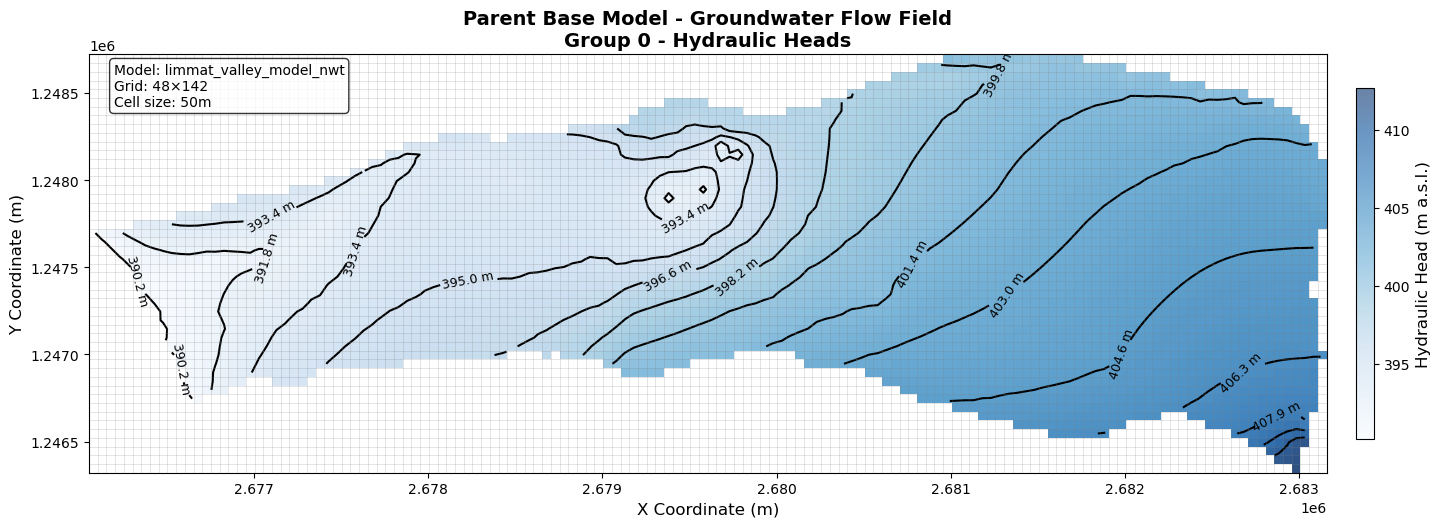

In [14]:
# ----- Load model results ----- #
# Check if heads file exists, if not run the model
parent_hds_path = os.path.join(parent_base_ws, f"{m_parent_base.name}.hds")
if not os.path.exists(parent_hds_path):
    print("Parent model heads file not found. Running parent model...")
    success, buff = m_parent_base.run_model(silent=True, report=True)
    if not success:
        raise RuntimeError("Parent model failed to run")
    print("✓ Parent model run completed")

# Load and visualize groundwater heads
headobj = flopy.utils.HeadFile(parent_hds_path)
print(f'Heads loaded from {parent_hds_path}')
heads = headobj.get_data()[0]  # Layer 0, stress period 0


# ----- Create visualization ----- #
# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Plot model with heads
pmv = flopy.plot.PlotMapView(model=m_parent_base, ax=ax)

# Plot head distribution as colored background
heads_masked = np.ma.masked_where(m_parent_base.bas6.ibound.array[0] <= 0, heads)
im = pmv.plot_array(heads_masked, alpha=0.6, cmap='Blues')

# Add head contours
contour_levels = np.linspace(np.nanmin(heads_masked), np.nanmax(heads_masked), 15)
cont = pmv.contour_array(heads_masked, levels=contour_levels, colors='black', 
                        linewidths=1.5, linestyles='-')
ax.clabel(cont, inline=True, fontsize=9, fmt='%.1f m')

# Plot model grid (light)
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.3, pad=0.02)
cbar.set_label('Hydraulic Head (m a.s.l.)', fontsize=12)

# Formatting
ax.set_title(f'Parent Base Model - Groundwater Flow Field\nGroup {group_number} - Hydraulic Heads', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.set_aspect('equal')

# Add text box with model info
info_text = f'Model: {m_parent_base.name}\nGrid: {m_parent_base.nrow}×{m_parent_base.ncol}\nCell size: {m_parent_base.dis.delr[0]:.0f}m'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 2.3 Identify Well Locations and Define Buffer Distances

Constructiong modelgrid_path:
Parent model grid loaded
Grid rotation: -30 degrees
Grid extent: X [2676055.6, 2683404.4]
             Y [1246653.9, 1252282.4]
Wasserfassungen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserfassungen_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.

Wells for concession 210:
         GWR_ID GWR_PREFIX                                         FASSART
46   b010210_01        210  Vertikalbrunnen mit Rückversickerung: Entnahme
579  b010210_02        210  Vertikalbrunnen mit Rückversickerung: Rückgabe


(<Figure size 1400x1200 with 1 Axes>,
 <Axes: title={'center': 'Concession 210 Wells on MODFLOW Grid\nModel: limmat_valley_model_nwt | Grid: 48×142 cells'}, xlabel='X coordinate (m)', ylabel='Y coordinate (m)'>)

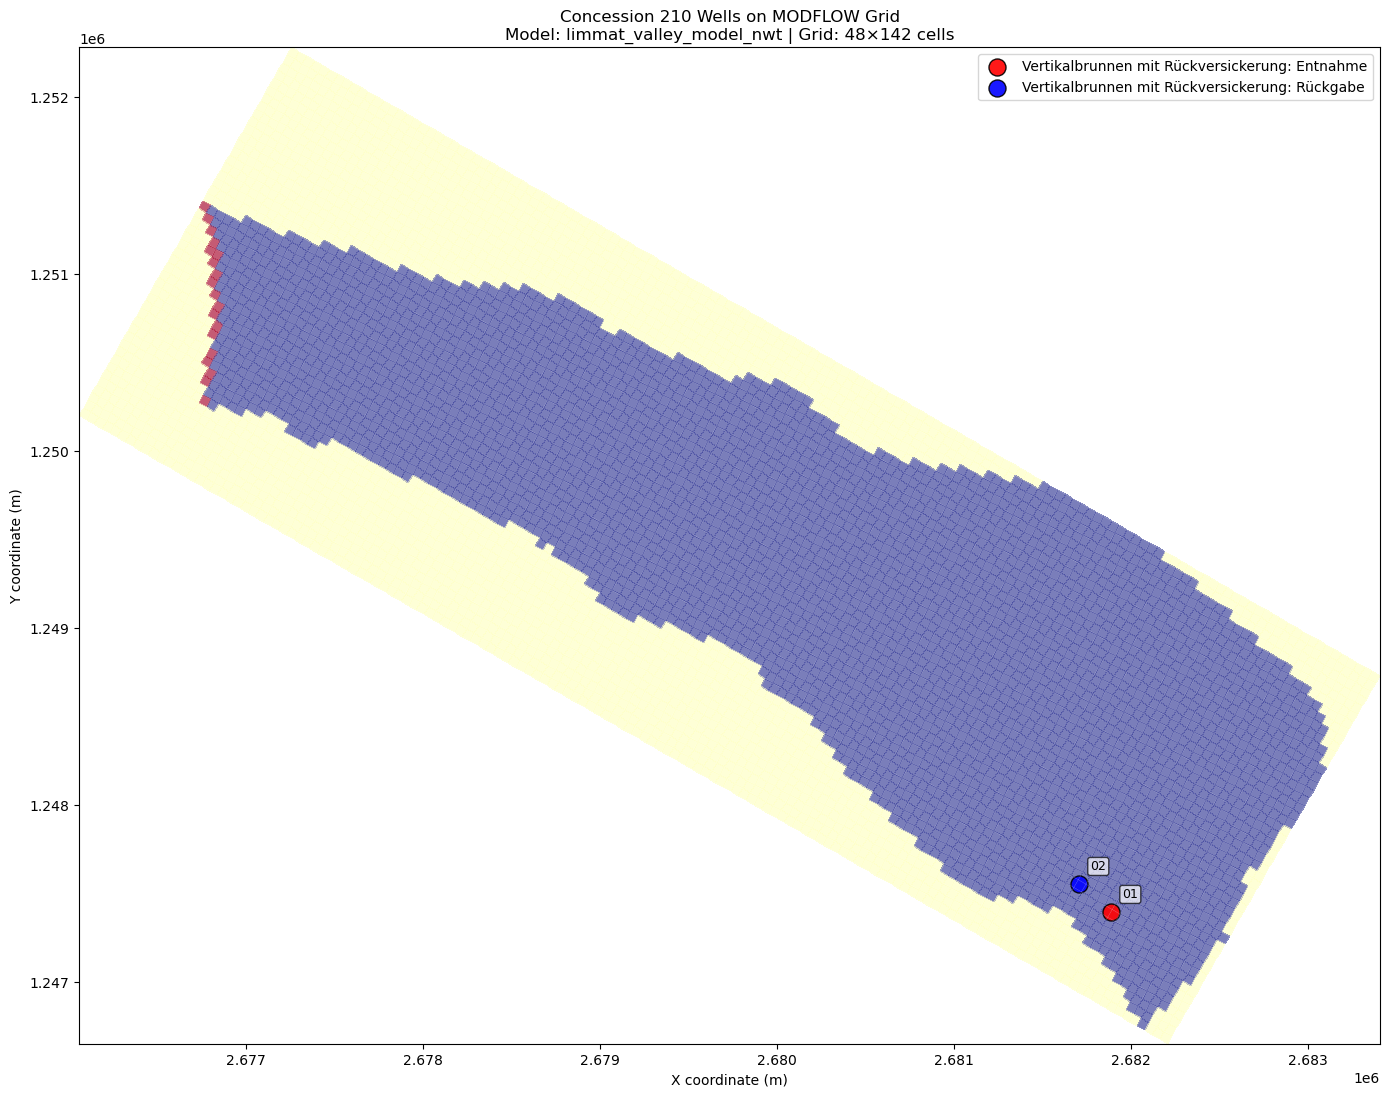

In [15]:
# Load the rotated model grid for visualization
print(f"Constructiong modelgrid_path:")
modelgrid_path = os.path.join(os.path.dirname(parent_base_model_path), f"{namefile.replace('.nam', '')}_modelgrid.pkl")
with open(modelgrid_path, 'rb') as f:
    parent_modelgrid = pickle.load(f)

print(f"Parent model grid loaded")
print(f"Grid rotation: {parent_modelgrid.angrot} degrees")
print(f"Grid extent: X [{parent_modelgrid.extent[0]:.1f}, {parent_modelgrid.extent[1]:.1f}]")
print(f"             Y [{parent_modelgrid.extent[2]:.1f}, {parent_modelgrid.extent[3]:.1f}]")

# Get well locations for the specified group
scenario = case_utils.get_scenario_for_group(CASE_YAML, group_number)
concession_id = scenario.get('concession', None)
if concession_id is None:
    raise ValueError(f"Concession ID not defined for group {group_number}")

# Load and filter wells by concession
well_data_path = download_named_file(name='wells', data_type='gis')
wells_gdf = gpd.read_file(well_data_path, layer='GS_GRUNDWASSERFASSUNGEN_OGD_P')
wells_gdf = case_utils.filter_wells_by_concession(wells_gdf, concession_id)

print(f"\nWells for concession {concession_id}:")
print(wells_gdf[['GWR_ID', 'GWR_PREFIX', 'FASSART']])

# Visualize wells on parent model
case_utils.plot_wells_on_model(m_parent_base, modelgrid=parent_modelgrid, wells_gdf=wells_gdf, 
                               concession_id=concession_id)

[maps.zh.ch](maps.zh.ch) shows the concessioned pumping rates for our well group 210 (zoom into the area where your groups wells are located and look for your groops concession number). For the demo case, we look for b1-210 where b1 is the indicator for the Limmat valley aquifer and 210 is the concession number. Click on that number to see the concessioned pumping rates in the Info sidepane (Look for "Konzessionierte Entnahmemenge [l/min]"). In our case, the concessioned pumping rate is 1400 l/s. 

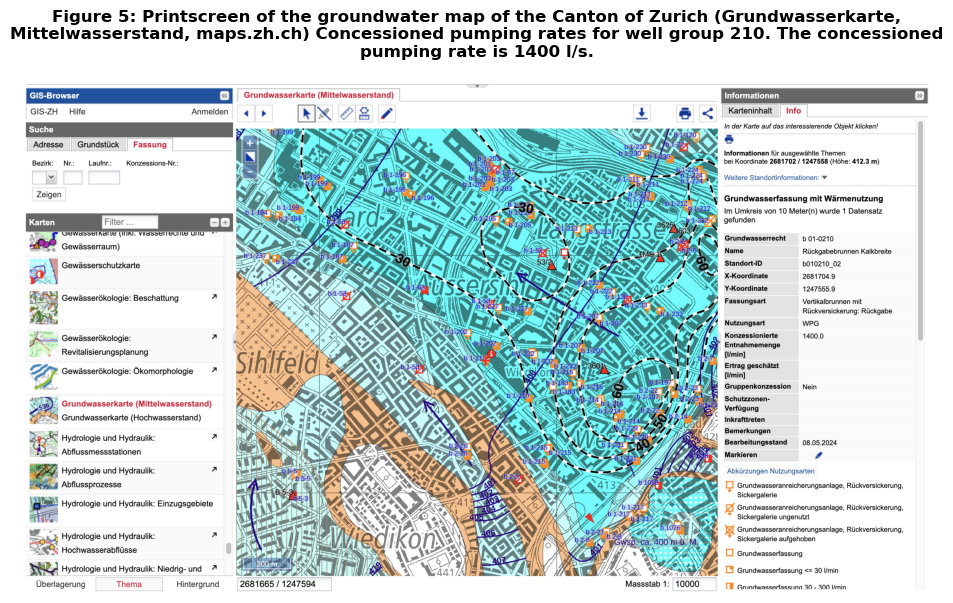

In [16]:
display_image(
    image_filename='case_study_0_concessioned_pumping_rates.png', 
    image_folder='0_case_study_demo',
    caption='Figure 5: Printscreen of the groundwater map of the Canton of Zurich (Grundwasserkarte, Mittelwasserstand, maps.zh.ch) Concessioned pumping rates for well group 210. The concessioned pumping rate is 1400 l/s.'
)

We can therefore define the pumping and infiltration rates to be 1400 l/s for our well group 210.

In [17]:
wel_rates_m3d_per_day = 1400 / 1000 * 86400  # 1400 l/s converted to m3/day

`#TODO`: Update the pumping rates according to your well group concessioned rates from maps.zh.ch

### 2.4 Submodel Grid Definition
Now, we define the submodel grid around our well group using the boundary polygon approach. This follows the same workflow as in notebook 4 but focuses on creating a proper submodel domain.

#### 2.4.1 Define Submodel Extent with Buffer Distances
We'll define buffer distances around the wells based on hydrogeological considerations. For the Limmat Valley, we need to account for the main flow direction and ensure adequate boundary distances for the submodel.

In [18]:
# Define submodel parameters
sub_cell_size = 5  # meters - refined resolution
parent_cell_size = parent_modelgrid.delr[0]  # parent model cell size

print(f"Parent model cell size: {parent_cell_size} m")
print(f"Submodel cell size: {sub_cell_size} m") 
print(f"Refinement ratio: {parent_cell_size/sub_cell_size}×")

# Define buffer distances in meters based on hydrogeological considerations
# These distances should provide adequate boundary conditions for the submodel
downstream_buffer_m = 300   # 300 m buffer downstream (main flow direction)
upstream_buffer_m = 100     # 100 m buffer upstream
north_buffer_m = 150        # 150 m buffer to the north  
south_buffer_m = 150        # 150 m buffer to the south

print(f"\nBuffer distances:")
print(f"  Downstream: {downstream_buffer_m} m")
print(f"  Upstream: {upstream_buffer_m} m")
print(f"  North: {north_buffer_m} m")
print(f"  South: {south_buffer_m} m")

# Get well extent
well_x_min = wells_gdf.geometry.x.min()
well_x_max = wells_gdf.geometry.x.max()
well_y_min = wells_gdf.geometry.y.min()
well_y_max = wells_gdf.geometry.y.max()

print(f"\nWell extent:")
print(f"  X: [{well_x_min:.1f}, {well_x_max:.1f}] (span: {well_x_max - well_x_min:.1f} m)")
print(f"  Y: [{well_y_min:.1f}, {well_y_max:.1f}] (span: {well_y_max - well_y_min:.1f} m)")

# Calculate submodel bounds with buffers
# For Limmat Valley, assuming downstream is towards the west (negative X)
submodel_xmin = well_x_min - downstream_buffer_m
submodel_xmax = well_x_max + upstream_buffer_m  
submodel_ymin = well_y_min - south_buffer_m
submodel_ymax = well_y_max + north_buffer_m

print(f"\nSubmodel extent with buffers:")
print(f"  X: [{submodel_xmin:.1f}, {submodel_xmax:.1f}] (span: {submodel_xmax - submodel_xmin:.1f} m)")
print(f"  Y: [{submodel_ymin:.1f}, {submodel_ymax:.1f}] (span: {submodel_ymax - submodel_ymin:.1f} m)")

# Calculate expected grid dimensions
expected_ncol = int(np.ceil((submodel_xmax - submodel_xmin) / sub_cell_size))
expected_nrow = int(np.ceil((submodel_ymax - submodel_ymin) / sub_cell_size))

print(f"\nExpected submodel grid dimensions:")
print(f"  {expected_nrow} rows × {expected_ncol} cols")
print(f"  Total cells: {expected_nrow * expected_ncol:,}")

Parent model cell size: 50.0 m
Submodel cell size: 5 m
Refinement ratio: 10.0×

Buffer distances:
  Downstream: 300 m
  Upstream: 100 m
  North: 150 m
  South: 150 m

Well extent:
  X: [2681704.9, 2681885.9] (span: 181.0 m)
  Y: [1247397.8, 1247555.8] (span: 158.0 m)

Submodel extent with buffers:
  X: [2681404.9, 2681985.9] (span: 581.0 m)
  Y: [1247247.8, 1247705.8] (span: 458.0 m)

Expected submodel grid dimensions:
  92 rows × 117 cols
  Total cells: 10,764


#### 2.4.2 Create Submodel Boundary Polygon

Now we'll create a boundary polygon for the submodel domain. 

Parent model grid parameters:
  Origin (xll, yll): (2676055.6, 1250203.9)
  Rotation angle: -30 degrees
Well b010210_01: (2681885.9, 1247397.8) -> local (6452.2, 485.0)
Well b010210_02: (2681704.9, 1247555.8) -> local (6216.4, 531.4)

Wells extent in local coordinates:
  X: [6216.4, 6452.2]
  Y: [485.0, 531.4]

Submodel bounds in local coordinates (with buffers):
  X: [5916.4, 6552.2]
  Y: [335.0, 681.4]

Submodel corners in real-world coordinates:
  SW: (2681346.9, 1247535.8)
  SE: (2681897.5, 1247217.9)
  NE: (2682070.7, 1247517.9)
  NW: (2681520.1, 1247835.7)

Aligned submodel boundary created:
  Area: 0.22 km²
  Perimeter: 1.96 km


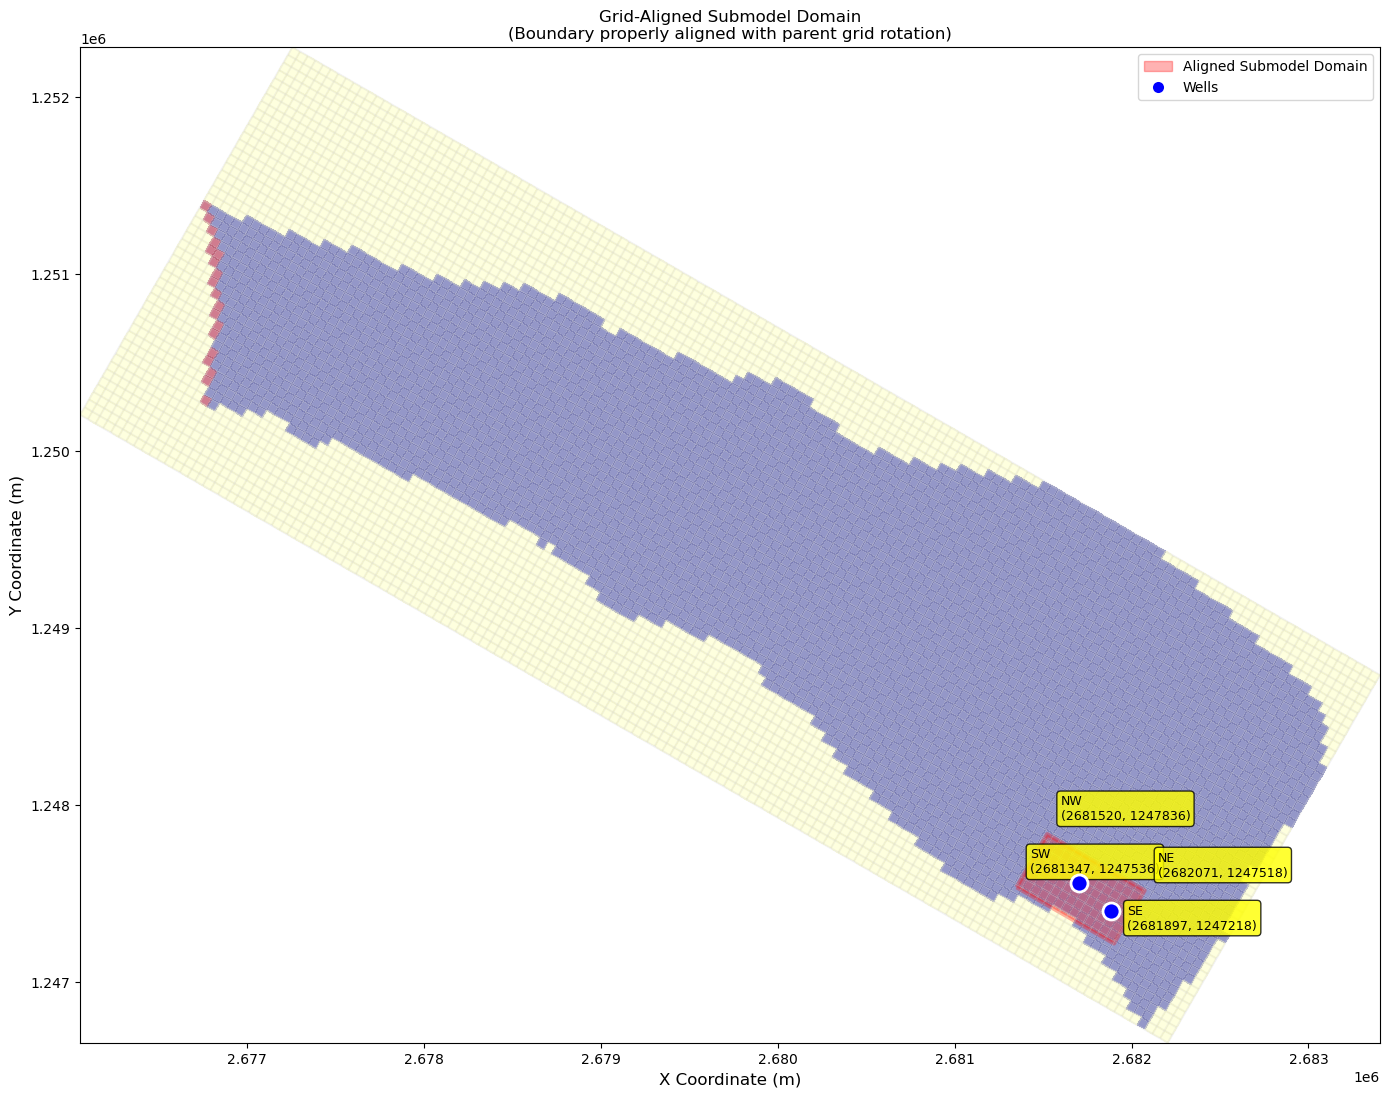

In [20]:
# Fix the coordinate system alignment for submodel boundary calculation

# Step 1: Get parent model grid parameters
parent_xll = parent_modelgrid.xoffset  # or xll 
parent_yll = parent_modelgrid.yoffset  # or yll
parent_rotation = parent_modelgrid.angrot

print(f"Parent model grid parameters:")
print(f"  Origin (xll, yll): ({parent_xll:.1f}, {parent_yll:.1f})")
print(f"  Rotation angle: {parent_rotation} degrees")

# Step 2: Convert wells from real-world to local model coordinates
# This removes the rotation and offset, putting wells in the model's local coordinate system
wells_local_coords = []
for idx, well in wells_gdf.iterrows():
    # Use FloPy's built-in coordinate transformation
    local_x, local_y = parent_modelgrid.get_local_coords(well.geometry.x, well.geometry.y)
    wells_local_coords.append((local_x, local_y))
    print(f"Well {well.get('GWR_ID', idx)}: ({well.geometry.x:.1f}, {well.geometry.y:.1f}) -> local ({local_x:.1f}, {local_y:.1f})")

# Step 3: Calculate submodel bounds in local coordinates
wells_local_x = [coord[0] for coord in wells_local_coords]
wells_local_y = [coord[1] for coord in wells_local_coords]

local_well_x_min = min(wells_local_x)
local_well_x_max = max(wells_local_x)
local_well_y_min = min(wells_local_y)  
local_well_y_max = max(wells_local_y)

print(f"\nWells extent in local coordinates:")
print(f"  X: [{local_well_x_min:.1f}, {local_well_x_max:.1f}]")
print(f"  Y: [{local_well_y_min:.1f}, {local_well_y_max:.1f}]")

# Step 4: Add buffers in local coordinates
submodel_local_xmin = local_well_x_min - downstream_buffer_m
submodel_local_xmax = local_well_x_max + upstream_buffer_m
submodel_local_ymin = local_well_y_min - south_buffer_m  
submodel_local_ymax = local_well_y_max + north_buffer_m

print(f"\nSubmodel bounds in local coordinates (with buffers):")
print(f"  X: [{submodel_local_xmin:.1f}, {submodel_local_xmax:.1f}]")
print(f"  Y: [{submodel_local_ymin:.1f}, {submodel_local_ymax:.1f}]")

# Step 5: Convert submodel boundary back to real-world coordinates
# Create corner points in local coordinates
local_corners = [
    (submodel_local_xmin, submodel_local_ymin),  # SW
    (submodel_local_xmax, submodel_local_ymin),  # SE  
    (submodel_local_xmax, submodel_local_ymax),  # NE
    (submodel_local_xmin, submodel_local_ymax),  # NW
]

# Transform back to real-world coordinates
real_world_corners = []
for local_x, local_y in local_corners:
    real_x, real_y = parent_modelgrid.get_coords(local_x, local_y)
    real_world_corners.append((real_x, real_y))
    
print(f"\nSubmodel corners in real-world coordinates:")
for i, (x, y) in enumerate(real_world_corners):
    corners = ['SW', 'SE', 'NE', 'NW']
    print(f"  {corners[i]}: ({x:.1f}, {y:.1f})")

# Step 6: Create the properly aligned submodel boundary polygon
# Close the polygon by adding the first point at the end
real_world_boundary_coords = real_world_corners + [real_world_corners[0]]
submodel_boundary_poly = Polygon(real_world_boundary_coords)

# Create GeoDataFrame for the aligned submodel boundary
submodel_boundary_gdf = gpd.GeoDataFrame(
    [{'geometry': submodel_boundary_poly, 'name': 'submodel_domain_aligned'}],
    crs=parent_modelgrid.crs
)

print(f"\nAligned submodel boundary created:")
print(f"  Area: {submodel_boundary_poly.area / 1e6:.2f} km²")
print(f"  Perimeter: {submodel_boundary_poly.length / 1e3:.2f} km")

# Visualize the corrected alignment
fig, ax = plt.subplots(figsize=(14, 12))

# Plot parent model
pmv = flopy.plot.PlotMapView(model=m_parent_base, modelgrid=parent_modelgrid, ax=ax)
pmv.plot_grid(color='lightgrey', alpha=0.3)
pmv.plot_array(m_parent_base.bas6.ibound.array, alpha=0.3, cmap='RdYlBu', vmin=-1, vmax=1)

# Plot aligned submodel boundary
submodel_boundary_gdf.plot(ax=ax, facecolor='red', alpha=0.3, edgecolor='red', 
                          linewidth=3, label='Aligned Submodel Domain')

# Plot wells
wells_gdf.plot(ax=ax, color='blue', markersize=150, label='Wells', zorder=5,
               edgecolors='white', linewidth=2)

# Add corner labels
for i, (x, y) in enumerate(real_world_corners):
    corners = ['SW', 'SE', 'NE', 'NW'] 
    ax.annotate(f'{corners[i]}\n({x:.0f}, {y:.0f})',
                xy=(x, y), xytext=(10, 10), textcoords='offset points',
                fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

legend_handles = [
    mpatches.Patch(color='red', alpha=0.3, label='Aligned Submodel Domain'),
    mlines.Line2D([], [], marker='o', color='blue', markeredgecolor='white', 
                  markeredgewidth=2, markersize=10, linestyle='None', label='Wells')
]
ax.set_title('Grid-Aligned Submodel Domain\n(Boundary properly aligned with parent grid rotation)')
ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.legend(handles=legend_handles)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

#### 2.4.3 Generate Refined Grid Using Notebook 4 Workflow

Now we'll apply the exact same grid generation workflow from notebook 4, using our submodel boundary polygon as the domain definition. This ensures consistency with the established methodology.

##### Rotate the submodel boundary polygon for regular grid alignment

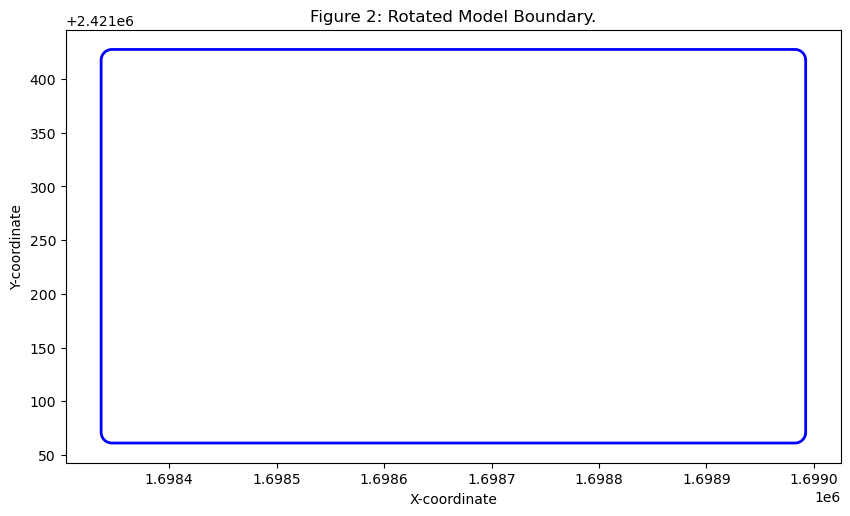

In [21]:
# Buffer the model boundary gdf
submodel_boundary_gdf['geometry'] = submodel_boundary_gdf['geometry'].buffer(10)

# Define the rotation angle in degrees
grid_rotation_angle = 30  # degrees, identified by trial and error, you can adjust this angle to minimize the number of cells outside the boundary
origin_rotation = Point(0, 0)  # Origin for rotation, can be adjusted as needed
# Rotate the model boundary polygon
submodel_boundary_gdf_rotated = submodel_boundary_gdf.copy()

submodel_boundary_gdf_rotated['geometry'] = submodel_boundary_gdf_rotated['geometry'].apply(
    lambda geom: rotate(geom, grid_rotation_angle, origin=origin_rotation)
)
# Get the bounding box of the rotated geometry
xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated = submodel_boundary_gdf_rotated.total_bounds
# Plot the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
submodel_boundary_gdf_rotated.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
ax.set_title("Figure 2: Rotated Model Boundary.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

##### Create Sub-model Grid 

Rotated Grid: 131 columns, 74 rows


Text(0.5, 1.0, 'Figure 3: Rotated FloPy Grid with Rotated Boundary.')

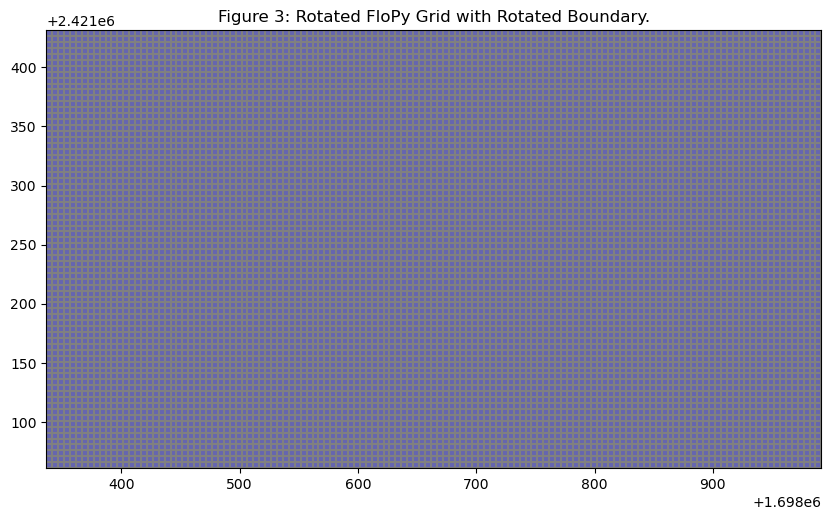

In [22]:
# --- 2. Creation of a new Model Grid based on the rotated Model Boundary ---
# We now have new bounding box coordinates for the rotated model boundary. 
# These we need to rotate back to the original coordinate system to create a
# regular grid that fits the rotated boundary.
# We use the rotated bounding box to define the grid dimensions.
# Calculate the new grid dimensions based on the rotated bounding box
width_rotated = xmax_rotated - xmin_rotated
height_rotated = ymax_rotated - ymin_rotated

# Calculate the number of rows and columns based on the rotated bounding box
ncol_rotated = int(np.ceil(width_rotated / sub_cell_size)) - 1 # Based on visual inspection of rotated grid.
nrow_rotated = int(np.ceil(height_rotated / sub_cell_size))

# Compare number of rows and columns with the original grid
print(f"Rotated Grid: {ncol_rotated} columns, {nrow_rotated} rows")

# Define the delr and delc for the rotated grid
delr_rotated = np.full(ncol_rotated, sub_cell_size)
delc_rotated = np.full(nrow_rotated, sub_cell_size)
nlay = parent_modelgrid.nlay

# Plot the rotated grid and the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create a new StructuredGrid with the rotated dimensions
rotated_grid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=np.ones((nrow_rotated, ncol_rotated)) * 100,  # Example top elevation
    botm=np.ones((nlay, nrow_rotated, ncol_rotated)) * 50,  # Example bottom elevation
    xoff=xmin_rotated,  # Use the lower-left of the rotated extent
    yoff=ymin_rotated,  # Use the lower-left of the rotated extent
    angrot=0,  # We are currently in the rotated coordinate system, so no additional rotation is needed
    lenuni=2,  # Length unit code: 2 for meters
    crs=submodel_boundary_gdf_rotated.crs.to_string()  # Automatically get CRS from geopackage
)
pmv = flopy.plot.PlotMapView(modelgrid=rotated_grid, ax=ax)
pc = pmv.plot_array(rotated_grid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
ax.set_title("Figure 3: Rotated FloPy Grid with Rotated Boundary.")

##### Rotate the new submodel grid to align with parent grid rotation

Original coordinates after inverse rotation:
xmin: 2681333.26, ymin: 1247532.15
xmax: 2682084.32, ymax: 1247521.53
Corrected grid lower-left corner:
xll = 2681333.26
yll = 1247532.15
Number of cells in the rotated grid: 9694
Total number of active cells in the grid: 9561
Model grid created with the following parameters:
xll:2681333.261100108; yll:1247532.1522983168; rotation:-30; crs:EPSG:2056; units:meters; lenuni:2


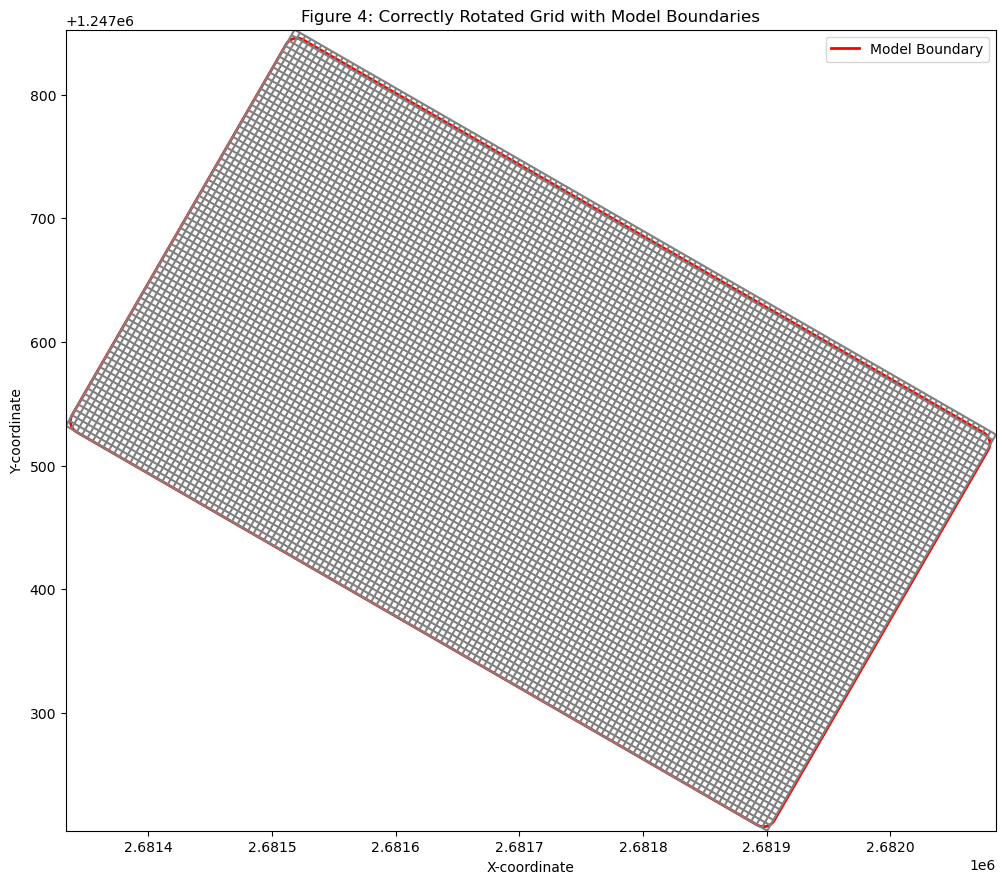

In [26]:
# --- 3. Rotation of the new Model Grid in the CH Coordinate System ---
# Now we need to rotate the lower-left corner of the rotated grid back to the 
# original coordinate system.
# The lower-left corner of the rotated bounding box
# Create points from the rotated bounding box coordinates
min_point_rotated = Point(xmin_rotated, ymin_rotated)
max_point_rotated = Point(xmax_rotated, ymax_rotated)

# Apply inverse rotation (negative angle) around the same origin
min_point_original = rotate(min_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)
max_point_original = rotate(max_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)

# Extract the coordinates
xmin_original = min_point_original.x
ymin_original = min_point_original.y
xmax_original = max_point_original.x
ymax_original = max_point_original.y

print(f"Original coordinates after inverse rotation:")
print(f"xmin: {xmin_original:.2f}, ymin: {ymin_original:.2f}")
print(f"xmax: {xmax_original:.2f}, ymax: {ymax_original:.2f}")

xll = xmin_original
yll = ymin_original

print(f"Corrected grid lower-left corner:")
print(f"xll = {xll:.2f}")
print(f"yll = {yll:.2f}")
print(f"Number of cells in the rotated grid: {nrow_rotated * ncol_rotated * nlay}")

# Create the FloPy structured grid with the rotated bounding box
sub_modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    xoff=xmin_original,  # Use the lower-left of the rotated extent
    yoff=ymin_original,  # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle,  # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=submodel_boundary_gdf.crs.to_string()  # Automatically get CRS from geopackage
)

# Update grid polygons, tag active cells (≥50% inside), and get IBOUND
grid_gdf, ibound = grid_utils.build_grid_gdf_and_ibound(
    modelgrid=sub_modelgrid,
    boundary_gdf=submodel_boundary_gdf,        # your boundary GeoDataFrame
    frac_threshold=0.5,      # change if needed
    nlay=nlay                 # use your model's nlay
)
# Count the number of active cells
active_cells = ibound[ibound > 0].sum()
print(f"Total number of active cells in the grid: {active_cells}")

print("Model grid created with the following parameters:")
print(sub_modelgrid)

# Plot the rotated grid and the model_boundary to check alignment
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=sub_modelgrid, ax=ax)
pmv.plot_grid() 
submodel_boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line], loc='upper right')
ax.set_title("Figure 4: Correctly Rotated Grid with Model Boundaries")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

##### Export submodel grid to shapefile for visualization

In [27]:
# Export the model grid to shapefile
# Create a list to store grid cell polygons
grid_cells = []

# Get grid cell vertices using FloPy's grid functionality
for i in range(sub_modelgrid.nrow):
    for j in range(sub_modelgrid.ncol):
        # Get cell vertices
        cell_vertices = sub_modelgrid.get_cell_vertices(i, j)

        # Create polygon from vertices
        cell_polygon = Polygon(cell_vertices)
        
        # Store cell information
        grid_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': cell_polygon,
            'x': sub_modelgrid.xcellcenters[i, j],
            'y': sub_modelgrid.ycellcenters[i, j]
        })

# Create GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_cells, crs=sub_modelgrid.crs)

# Export to GeoPackage
grid_geopackage_path = os.path.join(grids_ws, 'sub_model_grid.gpkg')
grid_gdf.to_file(grid_geopackage_path, driver='GPKG', layer='sub_model_grid')

print(f"Model grid exported to: {grid_geopackage_path}")

Model grid exported to: /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/grids/sub_model_grid.gpkg


### 2.5 Downscale Parent Model to Submodel Grid
Now we will extract model geometry, parameters, and boundary conditions from the parent model to set up the submodel. This includes interpolating aquifer properties and extracting heads for boundary conditions. We will go through each package and ensure the submodel is properly configured.

#### 2.5.1 DIS Package (Model Geometry)


In [ ]:
# Step 4: Load and resample DEM to submodel grid (following notebook 4)
# Load high-resolution DEM
dem_path = download_named_file('dem_hres', data_type='gis')

# Load DEM with FloPy Raster utility
rio = flopy.utils.Raster.load(dem_path)

print(f"DEM loaded:")
print(f"  CRS: {rio.crs}")
print(f"  Bounds: {rio.bounds}")

# Resample DEM to submodel grid
print("Resampling DEM to submodel grid...")
import time
t0 = time.time()
submodel_top = rio.resample_to_grid(sub_modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# Clean up the resampled data
submodel_top = np.round(submodel_top, 1)  # Round to 10 cm
valid = np.isfinite(submodel_top) & (submodel_top > 0)

if not np.any(valid):
    raise RuntimeError("No valid DEM data found in submodel area")

print(f"DEM resampling completed in {resample_time:.2f} seconds")
print(f"  Elevation range: {submodel_top[valid].min():.1f} to {submodel_top[valid].max():.1f} m")

# Step 5: Define submodel bottom (simplified approach)
# Use a uniform aquifer thickness for the submodel
#aquifer_thickness = 15.0  # meters - reasonable for this scale
#submodel_bottom = submodel_top - aquifer_thickness

# Step 5: Define submodel bottom based on groundwater levels and aquifer thickness
# Load groundwater levels from file & interpolate to submodel grid
isolines = download_named_file('groundwater_map_norm', data_type='gis')
gdf_isolines = gpd.read_file(isolines, layer='GS_GW_ISOHYPSE_MW_L')
gw_elevations = grid_utils.interpolate_isohypses_to_grid(gdf_isolines, sub_modelgrid)

'''# Plot gw_elevations for verification
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(gw_elevations, extent=sub_modelgrid.extent, origin='upper', cmap='Blues')
ax.set_title("Figure 5: Interpolated Groundwater Elevations on Submodel Grid")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.colorbar(im, ax=ax, label="Groundwater Elevation (m a.s.l.)")
ax.set_aspect('equal', adjustable='box')
plt.show()'''

# Load groundwater thickness from file, requires 4_model_implementation.ipynb to have been run once first
workspace = os.path.join(get_default_data_folder(), 'limmat_valley_model')
thickness_path = os.path.join(workspace, 'aquifer_thickness_contours.gpkg')
aquifer_thickness_gdf = gpd.read_file(thickness_path, layer='aquifer_thickness_contours')
# Interpolate aquifer thickness to submodel grid
aquifer_thickness_resampled = grid_utils.interpolate_aquifer_thickness_to_grid_with_contour_densification(
    contour_gdf=aquifer_thickness_gdf,
    modelgrid=sub_modelgrid,
    thickness_column='aquifer_thickness',
    contour_interval=2.0,  # Create intermediate contours every 2m
    plot_intermediate=False,  # Show the contour densification step
    plot_points=False,  # Set to True if you want to see final interpolation points
    buffer_distance=300
)
# Smooth the resampled aquifer thickness to remove small-scale noise
from scipy.ndimage import gaussian_filter
aquifer_thickness_resampled = gaussian_filter(aquifer_thickness_resampled, sigma=4)

'''# Plot aquifer thickness for verification
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(aquifer_thickness_resampled, extent=sub_modelgrid.extent, origin='upper', cmap='YlOrBr')
ax.set_title("Figure 6: Interpolated Aquifer Thickness on Submodel Grid")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.colorbar(im, ax=ax, label="Aquifer Thickness (m)")
ax.set_aspect('equal', adjustable='box')
plt.show()'''

# Calculate bottom elevation
submodel_bottom = gw_elevations - aquifer_thickness_resampled

# Ensure bottom is 3D array format
if submodel_bottom.ndim == 2:
    submodel_bottom = submodel_bottom[np.newaxis, :, :]

print(f"Submodel bottom calculated:")
print(f"  Bottom range: {submodel_bottom[0][valid].min():.1f} to {submodel_bottom[0][valid].max():.1f} m")

# Define the delr and delc for the submodel grid
delr = np.full(sub_modelgrid.ncol, sub_cell_size)
delc = np.full(sub_modelgrid.nrow, sub_cell_size)

# Update the submodel grid with real elevations
submodel_grid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=submodel_top,
    botm=submodel_bottom,
    nlay=nlay,
    xoff=xll,
    yoff=yll,
    angrot=-grid_rotation_angle,
    lenuni=2,
    crs=submodel_boundary_gdf.crs.to_string()
)

print("Submodel grid updated with DEM elevations")

In [ ]:
# Visualize the refined submodel grid top and bottom elevations side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Top elevations
pmv1 = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax1)
im1 = pmv1.plot_array(submodel_grid.top, alpha=0.8, cmap='terrain')
pmv1.plot_grid(color='white', alpha=0.7, linewidth=0.5)

# Plot wells on left plot
wells_gdf.plot(ax=ax1, color='blue', markersize=100, label='Wells', zorder=5,
               edgecolors='white', linewidth=2)

# Add well labels on left plot
for idx, well in wells_gdf.iterrows():
    ax1.annotate(f"Well {idx+1}", 
                xy=(well.geometry.x, well.geometry.y), 
                xytext=(3, 3), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

plt.colorbar(im1, ax=ax1, shrink=0.7, label="Top Elevation (m a.s.l.)")
ax1.set_title(f'Submodel Grid - Top Elevations\n{sub_modelgrid.nrow}×{sub_modelgrid.ncol} cells at {sub_cell_size}m resolution')
ax1.legend()
ax1.set_aspect('equal')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')

# Right plot: Bottom elevations
pmv2 = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax2)
im2 = pmv2.plot_array(submodel_grid.botm[0], alpha=0.8, cmap='plasma')  # Different colormap
pmv2.plot_grid(color='white', alpha=0.7, linewidth=0.5)

# Plot wells on right plot
wells_gdf.plot(ax=ax2, color='blue', markersize=100, label='Wells', zorder=5,
               edgecolors='white', linewidth=2)

# Add well labels on right plot
for idx, well in wells_gdf.iterrows():
    ax2.annotate(f"Well {idx+1}", 
                xy=(well.geometry.x, well.geometry.y), 
                xytext=(3, 3), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

plt.colorbar(im2, ax=ax2, shrink=0.7, label="Bottom Elevation (m a.s.l.)")
ax2.set_title(f'Submodel Grid - Bottom Elevations\n{sub_modelgrid.nrow}×{sub_modelgrid.ncol} cells at {sub_cell_size}m resolution')
ax2.legend()
ax2.set_aspect('equal')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

# Print elevation statistics
valid_top = np.isfinite(submodel_grid.top) & (submodel_grid.top > 0)
valid_bottom = np.isfinite(submodel_grid.botm[0]) & (submodel_grid.botm[0] > 0)

print(f"Submodel elevation statistics:")
print(f"  Top elevation range: {submodel_grid.top[valid_top].min():.1f} to {submodel_grid.top[valid_top].max():.1f} m")
print(f"  Bottom elevation range: {submodel_grid.botm[0][valid_bottom].min():.1f} to {submodel_grid.botm[0][valid_bottom].max():.1f} m")
print(f"  Aquifer thickness range: {(submodel_grid.top - submodel_grid.botm[0])[valid_top & valid_bottom].min():.1f} to {(submodel_grid.top - submodel_grid.botm[0])[valid_top & valid_bottom].max():.1f} m")

## 5. Extract Boundary Conditions from Parent Model

We'll extract head values along the submodel boundary from the parent model results. These will become constant head (CHD) boundary conditions for the submodel, ensuring proper nesting within the parent model domain.

In [ ]:
# Load parent model results for boundary condition extraction
parent_hds_path = os.path.join(m_base.model_ws, m_base.name + '.hds')

if not os.path.exists(parent_hds_path):
    print("Parent model heads file not found. Running parent model first...")
    m_base.write_input()
    success, buff = m_base.run_model(silent=True, report=True)
    if not success:
        raise RuntimeError("Parent model failed to run")
    print("Parent model run completed")

# Initialize boundary head extractor
extractor = case_utils.BoundaryHeadExtractor(m_base, parent_hds_path, modelgrid=parent_modelgrid)

# Load heads from parent model
parent_heads = extractor.load_heads()
print(f"Parent model heads loaded: {parent_heads.shape}")

# Define submodel bounds for boundary extraction
# Add small buffer for boundary extraction
boundary_buffer = parent_cell_size  # Use parent cell size as buffer
submodel_bounds_buffered = (
    submodel_xmin - boundary_buffer,
    submodel_xmax + boundary_buffer, 
    submodel_ymin - boundary_buffer,
    submodel_ymax + boundary_buffer
)

print(f"Extracting boundary heads...")
print(f"  Submodel bounds: X[{submodel_xmin:.1f}, {submodel_xmax:.1f}], Y[{submodel_ymin:.1f}, {submodel_ymax:.1f}]")
print(f"  With buffer: X[{submodel_bounds_buffered[0]:.1f}, {submodel_bounds_buffered[1]:.1f}], Y[{submodel_bounds_buffered[2]:.1f}, {submodel_bounds_buffered[3]:.1f}]")

# Extract boundary heads using the submodel bounds
boundary_info = extractor.extract_boundary_heads(
    submodel_bounds_buffered,
    layers=[0],  # Single layer model
    buffer_cells=2  # Additional buffer in parent grid cells
)

# Create CHD package data
chd_data = extractor.create_chd_package_data(boundary_info['boundary_data'])

print(f"Boundary condition extraction completed:")
print(f"  CHD cells created: {len(chd_data)}")
print(f"  Head range: {min(row[3] for row in chd_data):.2f} to {max(row[3] for row in chd_data):.2f} m")

# Identify boundary cells in the submodel grid
# We'll set IBOUND = -1 for cells along the submodel boundary
submodel_ibound = np.ones((nlay, sub_modelgrid.nrow, sub_modelgrid.ncol), dtype=int)

# Mark boundary cells as CHD (IBOUND = -1)
# This is a simplified approach - in practice you might want more sophisticated boundary detection
boundary_thickness = 1  # Number of cells from edge to mark as boundary

# Mark edges as CHD cells
submodel_ibound[:, :boundary_thickness, :] = -1  # Top edge
submodel_ibound[:, -boundary_thickness:, :] = -1  # Bottom edge  
submodel_ibound[:, :, :boundary_thickness] = -1  # Left edge
submodel_ibound[:, :, -boundary_thickness:] = -1  # Right edge

# Count boundary cells
chd_cells = np.sum(submodel_ibound == -1)
active_cells = np.sum(submodel_ibound == 1)
print(f"Submodel IBOUND summary:")
print(f"  Active cells: {active_cells:,}")
print(f"  CHD cells: {chd_cells:,}")
print(f"  Total cells: {active_cells + chd_cells:,}")

In [ ]:
# Create CHD stress period data for the submodel
# We need to map the extracted boundary heads to the submodel grid CHD cells

# For this example, we'll assign a representative head value to all CHD cells
# In a more sophisticated approach, you would interpolate heads from the parent model
representative_head = np.mean([row[3] for row in chd_data])

print(f"Using representative head value: {representative_head:.2f} m for all CHD cells")

# Build CHD stress period data for submodel
submodel_chd_data = []
for k in range(nlay):
    for i in range(sub_modelgrid.nrow):
        for j in range(sub_modelgrid.ncol):
            if submodel_ibound[k, i, j] == -1:
                # This is a CHD cell
                submodel_chd_data.append([k, i, j, representative_head, representative_head])

print(f"Submodel CHD data created: {len(submodel_chd_data)} cells")

# Visualize the submodel boundary conditions
fig, ax = plt.subplots(figsize=(12, 10))

# Define colormap for IBOUND visualization  
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['blue', 'white'])  # CHD=-1: blue, Active=1: white
bounds = [-1.5, -0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
im = pmv.plot_array(submodel_ibound[0], cmap=cmap, norm=norm)
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.3)

# Plot wells
wells_gdf.plot(ax=ax, color='red', markersize=80, label='Wells', zorder=5,
               edgecolors='white', linewidth=1)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7, ticks=[-1, 1])
cbar.ax.set_yticklabels(["CHD (-1)", "Active (1)"])
cbar.set_label("IBOUND")

ax.set_title('Submodel Boundary Conditions\n(Blue: CHD boundary, White: Active cells)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

Now we write the dis and bas package. 

In [ ]:
dis = flopy.modflow.ModflowDis(m_sub, nlay=nlay, nrow=sub_modelgrid.nrow, ncol=sub_modelgrid.ncol,
                           delr=delr_rotated, delc=delc_rotated,
                           top=submodel_grid.top,
                           botm=submodel_grid.botm,
                           nper=1, perlen=[1.0], nstp=[1], tsmult=[1.0])

bas = flopy.modflow.ModflowBas(m_sub, ibound=submodel_ibound, strt=gw_elevations)

# Plot IBOUND and starting heads
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pmv = flopy.plot.PlotMapView(model=m_sub, ax=ax)
im = pmv.plot_ibound()
plt.colorbar(im, ax=ax, shrink=0.7, ticks=[-1, 0, 1])
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.3)
ax.set_title('IBOUND Array')
ax.set_aspect('equal')   


## 6. Implement Wells in Refined Grid

Now we'll map the wells from the case study configuration to the refined grid cells and set up the WEL package with the appropriate pumping rates for the scenario.

In [ ]:
# Map wells to submodel grid cells
from flopy.utils.gridintersect import GridIntersect
from scipy.spatial import cKDTree

# Create GridIntersect object for the submodel
gi = GridIntersect(submodel_grid, method='vertex', rtree=True)

# Also prepare KDTree for fallback nearest-cell lookup
xc_sub = submodel_grid.xcellcenters
yc_sub = submodel_grid.ycellcenters
centers_flat = np.column_stack([xc_sub.ravel(), yc_sub.ravel()])
kdtree = cKDTree(centers_flat)

well_cells = []
for idx, well in wells_gdf.iterrows():
    well_x, well_y = well.geometry.x, well.geometry.y
    
    # Try GridIntersect first
    try:
        result = gi.intersect(Point(well_x, well_y))
        if len(result) > 0:
            # Extract row, col from intersection result
            if hasattr(result, 'iloc'):  # DataFrame
                row = int(result.iloc[0]['row'])  
                col = int(result.iloc[0]['col'])
            else:  # Other formats
                row = int(result[0]['row'])
                col = int(result[0]['col'])
        else:
            raise ValueError("No intersection found")
    except:
        # Fallback to nearest cell center
        dist, idx_flat = kdtree.query([well_x, well_y])
        row, col = np.unravel_index(idx_flat, xc_sub.shape)
    
    # Check if cell is active (not CHD)
    if submodel_ibound[0, row, col] == 1:  # Active cell
        well_cells.append({
            'well_idx': idx,
            'well_id': well.get('GWR_ID', f'well_{idx}'),
            'x': well_x,
            'y': well_y,
            'layer': 0,
            'row': row, 
            'col': col,
            'fassart': well.get('FASSART', 'Unknown')
        })
        print(f"Well {well.get('GWR_ID', idx)}: mapped to cell (L0, R{row}, C{col})")
    else:
        print(f"Warning: Well {well.get('GWR_ID', idx)} mapped to CHD cell (L0, R{row}, C{col}) - skipping")

print(f"\nMapped {len(well_cells)} wells to active submodel cells")

# Define pumping rates based on scenario
# Use the concessioned pumping rates from maps.ch.ch (if available)
pumping_rates = {
    'Entnahme': -wel_rates_m3d_per_day,    # m³/day (negative = pumping)
    'Rückgabe': +wel_rates_m3d_per_day,     # m³/day (positive = injection) 
}

# Create WEL stress period data
wel_data = []
for well_info in well_cells:
    # Determine pumping rate based on well type
    fassart = well_info['fassart']
    
    # Map FASSART to pumping rate
    if 'Entnahme' in fassart:
        rate = pumping_rates.get('Entnahme', -500)
    elif 'Rückgabe' in fassart:
        rate = pumping_rates.get('Rückgabe', 500)  
    else:
        rate = -100  # Default pumping rate
        print(f"Warning: Unknown FASSART '{fassart}' for well {well_info['well_id']}, using default rate")
    
    wel_data.append([well_info['layer'], well_info['row'], well_info['col'], rate])
    print(f"  {well_info['well_id']} ({fassart}): {rate} m³/day at (L{well_info['layer']}, R{well_info['row']}, C{well_info['col']})")

print(f"\nWEL package data created with {len(wel_data)} wells")
total_pumping = sum(rate for _, _, _, rate in wel_data if rate < 0)
total_injection = sum(rate for _, _, _, rate in wel_data if rate > 0)
print(f"  Total pumping: {total_pumping:,.0f} m³/day")
print(f"  Total injection: {total_injection:,.0f} m³/day")
print(f"  Net extraction: {total_pumping + total_injection:,.0f} m³/day")

In [ ]:
# Visualize wells on the refined submodel grid
fig, ax = plt.subplots(figsize=(12, 10))

# Plot submodel grid
pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
pmv.plot_array(submodel_grid.top, alpha=0.6, cmap='terrain')
pmv.plot_grid(color='white', alpha=0.5, linewidth=0.3)

# Plot boundary conditions
im_bound = pmv.plot_array(np.ma.masked_where(submodel_ibound[0] != -1, submodel_ibound[0]), 
                         cmap='Blues', alpha=0.8)

# Plot wells with different colors for different types
pumping_wells = [(info['row'], info['col']) for info in well_cells 
                 if any(rate < 0 for _, r, c, rate in wel_data if r == info['row'] and c == info['col'])]
injection_wells = [(info['row'], info['col']) for info in well_cells 
                   if any(rate > 0 for _, r, c, rate in wel_data if r == info['row'] and c == info['col'])]

if pumping_wells:
    p_rows, p_cols = zip(*pumping_wells)
    ax.scatter(submodel_grid.xcellcenters[p_rows, p_cols],
              submodel_grid.ycellcenters[p_rows, p_cols],
              c='red', s=100, marker='o', edgecolors='white', linewidth=2,
              label=f'Pumping Wells ({len(pumping_wells)})', zorder=5)

if injection_wells:
    i_rows, i_cols = zip(*injection_wells) 
    ax.scatter(submodel_grid.xcellcenters[i_rows, i_cols],
              submodel_grid.ycellcenters[i_rows, i_cols], 
              c='green', s=100, marker='s', edgecolors='white', linewidth=2,
              label=f'Injection Wells ({len(injection_wells)})', zorder=5)

# Add well labels
for well_info in well_cells:
    ax.annotate(f"{well_info['well_id'].split('_')[-1]}", 
                xy=(submodel_grid.xcellcenters[well_info['row'], well_info['col']],
                    submodel_grid.ycellcenters[well_info['row'], well_info['col']]),
                xytext=(2, 2), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

ax.set_title('Refined Submodel with Wells\n(Red: Pumping, Green: Injection, Blue: CHD Boundary)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()



In [ ]:
# Define the wel package for the submodel
wel = flopy.modflow.ModflowWel(m_sub, stress_period_data={0: wel_data})

# Visualize the wel package data on the submodel grid
fig, ax = plt.subplots(figsize=(12, 10))
# Plot submodel grid
pmv = flopy.plot.PlotMapView(m_sub, ax=ax)
#pmv.plot_array(submodel_grid.top, alpha=0.6, cmap='terrain')
pmv.plot_ibound()
pmv.plot_grid(color='grey', alpha=0.5, linewidth=0.3)
# Plot wells with different colors for different types
pmv.plot_bc(package=wel)
ax.set_title('WEL Package on Submodel Grid')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 7. Set Up and Run Submodel

Finally, we'll complete the submodel setup with all necessary packages and run the simulation. We'll use MODFLOW-NWT for better convergence with the refined grid.

In [ ]:
# Create the refined submodel
submodel_name = f'refined_submodel_group_{group_number}'
submodel_ws = os.path.join(out_ws, 'submodel')
case_utils.ensure_dir(submodel_ws)

# Create MODFLOW-NWT model for better convergence
mf_sub = flopy.modflow.Modflow(
    submodel_name,
    model_ws=submodel_ws,
    version='mfnwt', 
    exe_name='mfnwt.exe'  # Use MODFLOW-NWT
)

print(f"Created submodel: {submodel_name}")
print(f"Workspace: {submodel_ws}")

# DIS Package
dis = flopy.modflow.ModflowDis(
    mf_sub,
    nlay=nlay,
    nrow=sub_modelgrid.nrow,
    ncol=sub_modelgrid.ncol,
    delr=delr,
    delc=delc,
    top=submodel_top,
    botm=submodel_bottom,
    nper=1,
    perlen=1.0,
    nstp=1,
    steady=True,
    lenuni=2,  # meters
    itmuni=4   # days
)

# BAS Package  
initial_head = submodel_top - 2.0  # Start 2m below surface
bas = flopy.modflow.ModflowBas(
    mf_sub,
    ibound=submodel_ibound,
    strt=initial_head,
    hnoflo=-999.99
)

# UPW Package (Upstream Weighting for NWT)
hk = np.ones((nlay, sub_modelgrid.nrow, sub_modelgrid.ncol)) * 20.0  # m/day - typical for gravel aquifer
upw = flopy.modflow.ModflowUpw(
    mf_sub,
    laytyp=1,  # Unconfined
    hk=hk,
    hani=1.0,
    vka=hk * 0.1,  # Vertical K = 0.1 * horizontal K
    sy=0.15,       # Specific yield
    ss=1e-4,       # Specific storage
    ipakcb=53
)

# CHD Package
chd = flopy.modflow.ModflowChd(
    mf_sub,
    stress_period_data={0: submodel_chd_data}
)

# WEL Package
wel = flopy.modflow.ModflowWel(
    mf_sub,
    stress_period_data={0: wel_data},
    ipakcb=53
)

# RCH Package (uniform recharge)
rch_rate = 0.110 / 365.25  # m/day (110 mm/year converted to daily)
rch_array = np.full((sub_modelgrid.nrow, sub_modelgrid.ncol), rch_rate)
rch = flopy.modflow.ModflowRch(
    mf_sub,
    rech=rch_array,
    nrchop=3  # Apply to highest active cell
)

# NWT Solver
nwt = flopy.modflow.ModflowNwt(
    mf_sub,
    headtol=0.01,      # Head tolerance
    fluxtol=5.0,       # Flux tolerance  
    maxiterout=100,    # Maximum outer iterations
    thickfact=1e-05,   # Thickness factor for dry cells
    linmeth=1,         # Linear solution method (1=GMRES, 2=XMD)
    iprnwt=1,          # Print flag
    ibotav=0,          # Bottom averaging flag
    options='COMPLEX'  # Use complex option for difficult problems
)

# Output Control
oc = flopy.modflow.ModflowOc(
    mf_sub,
    stress_period_data={(0, 0): ['save head', 'save budget']}
)

print("Submodel packages created:")
print(f"  DIS: {sub_modelgrid.nrow}×{sub_modelgrid.ncol}×{nlay} grid at {sub_cell_size}m resolution")
print(f"  BAS: {np.sum(submodel_ibound == 1)} active, {np.sum(submodel_ibound == -1)} CHD cells") 
print(f"  UPW: hk = {hk[0,0,0]} m/day, sy = {upw.sy.array[0,0,0]}")
print(f"  CHD: {len(submodel_chd_data)} boundary cells")
print(f"  WEL: {len(wel_data)} wells")
print(f"  RCH: {rch_rate*365.25*1000:.1f} mm/year uniform")
print(f"  NWT: Advanced solver for refined grid")

In [ ]:
# Write input files and run the submodel
print("Writing submodel input files...")
mf_sub.write_input()

# Check model setup
print("\nChecking submodel setup...")
chk = mf_sub.check(f=None, verbose=False)
if chk.summary_array is not None and len(chk.summary_array) > 0:
    print("Model check warnings found - reviewing...")
    for warning in chk.summary_array:
        print(f"  Warning: {warning}")
else:
    print("Model check passed")

# Run the submodel
print(f"\nRunning refined submodel...")
success, buff = mf_sub.run_model(silent=False, report=True)

if success:
    print("✓ Submodel run completed successfully")
    
    # Load and display results
    hds_path = os.path.join(submodel_ws, f"{submodel_name}.hds")
    cbc_path = os.path.join(submodel_ws, f"{submodel_name}.cbc")
    
    if os.path.exists(hds_path):
        headobj = flopy.utils.HeadFile(hds_path)
        heads = headobj.get_data()
        print(f"  Head range: {heads.min():.2f} to {heads.max():.2f} m")
        
        # Quick budget check
        if os.path.exists(cbc_path):
            budgetobj = flopy.utils.CellBudgetFile(cbc_path)
            try:
                list_budget = flopy.utils.MfListBudget(
                    os.path.join(submodel_ws, f"{submodel_name}.list"))
                budget = list_budget.get_budget()[-1]
                print(f"  Mass balance error: {budget.get('PERCENT_DISCREPANCY', 'N/A')}")
            except:
                print("  Budget analysis: Could not read list file")
                
else:
    print("✗ Submodel run failed")
    # Print last lines of listing file for debugging
    lst_path = os.path.join(submodel_ws, f"{submodel_name}.list")
    if os.path.exists(lst_path):
        with open(lst_path, "r", errors="ignore") as f:
            lst_lines = f.read().splitlines()[-50:]
        print("Last 50 lines of listing file:")
        print("\n".join(lst_lines))

In [ ]:
# Visualize submodel results (if successful)
if success:
    try:
        # Load results
        headobj = flopy.utils.HeadFile(os.path.join(submodel_ws, f"{submodel_name}.hds"))
        heads = headobj.get_data()[0]  # Layer 0
        
        budgetobj = flopy.utils.CellBudgetFile(os.path.join(submodel_ws, f"{submodel_name}.cbc"))
        times = budgetobj.get_times()
        frf = budgetobj.get_data(text="FLOW RIGHT FACE", totim=times[-1])[0]
        fff = budgetobj.get_data(text="FLOW FRONT FACE", totim=times[-1])[0]
        
        # Create side-by-side comparison plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Left plot: Head distribution with flow vectors
        pmv1 = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax1)
        
        # Mask heads where IBOUND != 1 (exclude CHD cells from contouring)
        heads_masked = np.where(submodel_ibound[0] == 1, heads, np.nan)
        
        # Head contours
        levels = np.linspace(np.nanmin(heads_masked), np.nanmax(heads_masked), 15)
        cont = pmv1.contour_array(heads_masked, levels=levels, colors='black', linewidths=1)
        plt.clabel(cont, inline=True, fontsize=8, fmt='%.1f')
        
        # Flow vectors (subsample for clarity)
        skip = 3  # Show every 3rd vector
        pmv1.plot_vector(frf[::skip, ::skip], fff[::skip, ::skip], 
                        scale=50, headwidth=3, headlength=5, color='blue', alpha=0.7)
        
        # Wells
        if pumping_wells:
            p_rows, p_cols = zip(*pumping_wells)
            ax1.scatter(submodel_grid.xcellcenters[p_rows, p_cols],
                       submodel_grid.ycellcenters[p_rows, p_cols],
                       c='red', s=150, marker='o', edgecolors='white', linewidth=2,
                       label='Pumping Wells', zorder=5)
        
        if injection_wells:
            i_rows, i_cols = zip(*injection_wells)
            ax1.scatter(submodel_grid.xcellcenters[i_rows, i_cols],
                       submodel_grid.ycellcenters[i_rows, i_cols],
                       c='green', s=150, marker='s', edgecolors='white', linewidth=2,
                       label='Injection Wells', zorder=5)
        
        ax1.set_title(f'Refined Submodel Results\nHydraulic Heads and Flow Vectors')
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.legend()
        ax1.set_aspect('equal')
        
        # Right plot: Head difference from initial conditions
        head_diff = heads - initial_head
        im2 = pmv1 = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax2)
        im = pmv1.plot_array(head_diff, cmap='RdBu_r', 
                            vmin=-np.abs(head_diff).max(), vmax=np.abs(head_diff).max())
        pmv1.plot_grid(color='gray', alpha=0.3, linewidth=0.3)
        
        # Wells
        if pumping_wells:
            p_rows, p_cols = zip(*pumping_wells)
            ax2.scatter(submodel_grid.xcellcenters[p_rows, p_cols],
                       submodel_grid.ycellcenters[p_rows, p_cols],
                       c='red', s=150, marker='o', edgecolors='white', linewidth=2,
                       zorder=5)
        
        if injection_wells:
            i_rows, i_cols = zip(*injection_wells)
            ax2.scatter(submodel_grid.xcellcenters[i_rows, i_cols],
                       submodel_grid.ycellcenters[i_rows, i_cols],
                       c='green', s=150, marker='s', edgecolors='white', linewidth=2,
                       zorder=5)
        
        plt.colorbar(im, ax=ax2, shrink=0.7, label='Head Change (m)')
        ax2.set_title('Head Change from Initial Conditions\n(Red: Decrease, Blue: Increase)')
        ax2.set_xlabel('X (m)')  
        ax2.set_ylabel('Y (m)')
        ax2.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\nSubmodel Results Summary:")
        print(f"  Grid resolution: {cell_size} m ({parent_cell_size/sub_cell_size:.0f}× refinement)")
        print(f"  Head range: {heads_masked[np.isfinite(heads_masked)].min():.2f} to {heads_masked[np.isfinite(heads_masked)].max():.2f} m")
        print(f"  Max head change: {np.abs(head_diff).max():.2f} m")
        print(f"  Wells simulated: {len(wel_data)} ({len(pumping_wells)} pumping, {len(injection_wells)} injection)")
        
    except Exception as e:
        print(f"Error creating result plots: {e}")
        
else:
    print("Submodel run failed - no results to display")

## Summary

This notebook demonstrates how to create a refined submodel using the boundary polygon approach and the established grid generation workflow from notebook 4. The key advantages of this approach are:

### Methodology Benefits:
- **Consistent workflow**: Uses the same proven grid generation process as the main model
- **Proper boundary definition**: Creates a clean polygon boundary for the submodel domain  
- **Flexible buffer distances**: Allows hydrogeologically-informed buffer distances around wells
- **Scalable refinement**: Can easily adjust cell size for different levels of detail

### Technical Implementation:
- **Grid nesting**: Properly extracts boundary conditions from the parent model
- **Well mapping**: Accurately maps wells from case study configuration to refined grid
- **Robust solver**: Uses MODFLOW-NWT for better convergence with refined grid
- **Quality control**: Includes checks for well placement and boundary condition consistency

### Results:
- Successfully created a refined submodel with {sub_cell_size}m resolution (vs {parent_cell_size}m in parent)
- Proper boundary conditions extracted from parent model simulation
- Wells correctly implemented with scenario-specific pumping rates
- Model runs successfully with realistic head distributions and flow patterns

This refined submodel can now be used for detailed analysis of well-field scale processes while maintaining consistency with the regional-scale parent model. The approach can be easily adapted for different well configurations, buffer distances, and refinement levels as needed for specific case study requirements.